In [17]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD  # Change optimizer to SGD
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, MultiHeadAttention

In [18]:
import pandas as pd

df = pd.read_csv('/content/AAPL.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-07-17,15.346429,15.436429,15.293571,15.368214,13.307113,198990400
1,2013-07-18,15.477857,15.531071,15.378929,15.420000,13.351951,218878800
2,2013-07-19,15.467857,15.499286,15.155357,15.176786,13.141359,268721600
3,2013-07-22,15.337857,15.348214,15.195357,15.225357,13.183416,207796400
4,2013-07-23,15.214286,15.248571,14.953929,14.963929,12.957050,369395600
...,...,...,...,...,...,...,...
2512,2023-07-11,189.160004,189.300003,186.600006,188.080002,187.579254,46638100
2513,2023-07-12,189.679993,191.699997,188.470001,189.770004,189.264740,60750200
2514,2023-07-13,190.500000,191.190002,189.779999,190.539993,190.032669,41342300
2515,2023-07-14,190.229996,191.179993,189.630005,190.690002,190.182281,41573900


In [19]:
#from sklearn.preprocessing import MinMaxScaler

# Adjust column names based on the actual column names in your DataFrame
#numerical_cols = ['Close']  # Adjusted column names

# Initialize the MinMaxScaler
#scaler = MinMaxScaler()

# Fit and transform the data, ensure your DataFrame is named df
#df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

#print(df.head())

In [20]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2013-07-17,15.368214
1,2013-07-18,15.420000
2,2013-07-19,15.176786
3,2013-07-22,15.225357
4,2013-07-23,14.963929
...,...,...
2512,2023-07-11,188.080002
2513,2023-07-12,189.770004
2514,2023-07-13,190.539993
2515,2023-07-14,190.690002


In [21]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2013-07-18')
datetime_object

datetime.datetime(2013, 7, 18, 0, 0)

In [22]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-22-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2013-07-17
1      2013-07-18
2      2013-07-19
3      2013-07-22
4      2013-07-23
          ...    
2512   2023-07-11
2513   2023-07-12
2514   2023-07-13
2515   2023-07-14
2516   2023-07-17
Name: Date, Length: 2517, dtype: datetime64[ns]

In [23]:
df.index = df.pop('Date')
df

,Close
Date,
2013-07-17,15.368214
2013-07-18,15.420000
2013-07-19,15.176786
2013-07-22,15.225357
2013-07-23,14.963929
...,...
2023-07-11,188.080002
2023-07-12,189.770004
2023-07-13,190.539993


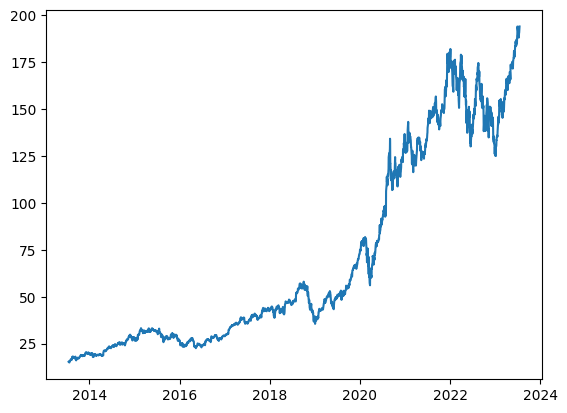

In [24]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [25]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2019-03-25',
                                '2023-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2019-03-25,47.040001,48.772499,47.762501,47.185001
1,2019-03-26,48.772499,47.762501,47.185001,46.697498
2,2019-03-27,47.762501,47.185001,46.697498,47.117500
3,2019-03-28,47.185001,46.697498,47.117500,47.180000
4,2019-03-29,46.697498,47.117500,47.180000,47.487499
...,...,...,...,...,...
1003,2023-03-17,152.589996,152.990005,155.850006,155.000000
1004,2023-03-20,152.990005,155.850006,155.000000,157.399994
1005,2023-03-21,155.850006,155.000000,157.399994,159.279999
1006,2023-03-22,155.000000,157.399994,159.279999,157.830002


In [26]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1008,), (1008, 3, 1), (1008,))

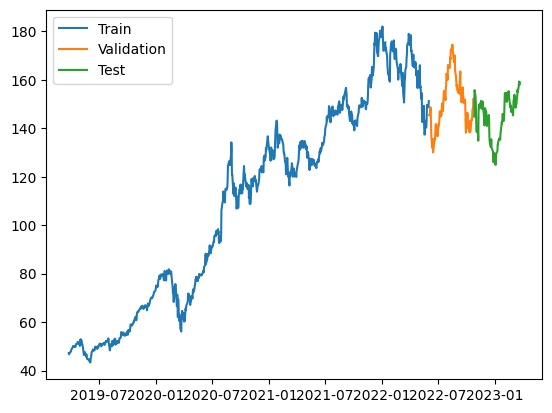

In [27]:

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [28]:
# Support Vector Machine (SVM) Regression
#svm_model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='linear'))
#svm_model.fit(X_train.squeeze(), y_train)

# Predictions
#y_train_pred_svm = svm_model.predict(X_train.squeeze())
#y_val_pred_svm = svm_model.predict(X_val.squeeze())
#y_test_pred_svm = svm_model.predict(X_test.squeeze())

In [29]:
# Random Forest Regression
#rf_model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
#rf_model.fit(X_train.squeeze(), y_train)

# Predictions
#y_train_pred_rf = rf_model.predict(X_train.squeeze())
#y_val_pred_rf = rf_model.predict(X_val.squeeze())
#y_test_pred_rf = rf_model.predict(X_test.squeeze())

Epoch 1/100
26/26 [==============================] - 4s 31ms/step - loss: 13318.8477 - mean_absolute_error: 107.7071 - val_loss: 22129.1270 - val_mean_absolute_error: 148.3499
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 12327.4414 - mean_absolute_error: 102.8717 - val_loss: 19952.5801 - val_mean_absolute_error: 140.8163
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 9911.3174 - mean_absolute_error: 90.1656 - val_loss: 15095.0039 - val_mean_absolute_error: 122.3522
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 5788.5244 - mean_absolute_error: 63.7297 - val_loss: 7320.9067 - val_mean_absolute_error: 84.8455
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 2381.9692 - mean_absolute_error: 41.5969 - val_loss: 2464.4968 - val_mean_absolute_error: 48.4050
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 1394.7767 - mean_absolute_error: 33.4742 - val_loss: 1376.799

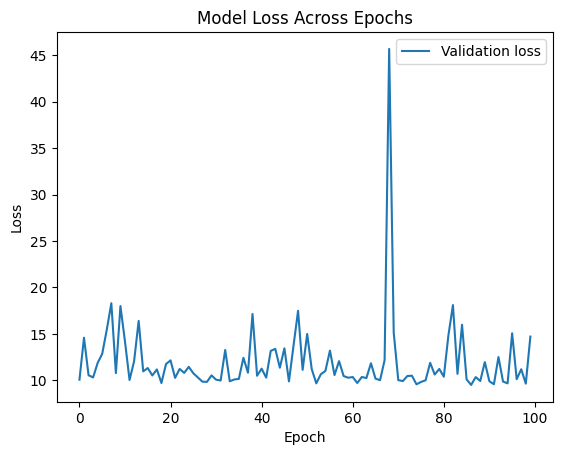

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

gru_model = Sequential([
    layers.Input((3, 1)),
    layers.GRU(64),  # Change LSTM to GRU
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

gru_model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mean_absolute_error']
)

gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

history = gru_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=100,
                         batch_size=32,
                         verbose=1)

#plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



Epoch 1/100
26/26 [==============================] - 3s 27ms/step - loss: 8328.7646 - root_mean_squared_error: 86.2734 - val_loss: 1073.7141 - val_root_mean_squared_error: 30.7631
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 1985.7406 - root_mean_squared_error: 44.3573 - val_loss: 2597.4561 - val_root_mean_squared_error: 49.5021
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 1266.1360 - root_mean_squared_error: 34.8449 - val_loss: 782.8422 - val_root_mean_squared_error: 26.2157
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 165.9598 - root_mean_squared_error: 10.5693 - val_loss: 25.4936 - val_root_mean_squared_error: 5.2269
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 17.2534 - root_mean_squared_error: 4.0300 - val_loss: 12.6694 - val_root_mean_squared_error: 3.5862
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 8.9114 - root_mean_squared_error: 2.9089 -

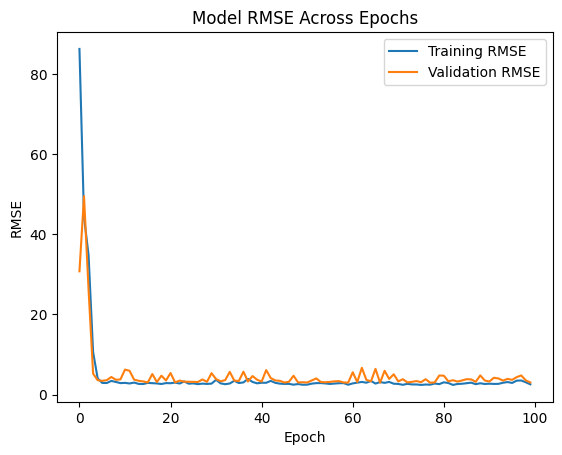

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Custom RMSE metric
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Model definition remains the same
gru_model = Sequential([
    Input((3, 1)),
    GRU(64),  # Using GRU instead of LSTM
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model with the custom RMSE metric
gru_model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.005),
    metrics=[root_mean_squared_error]  # Here we use RMSE
)

# Fit the model once, saving the history
history = gru_model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=100,
                        batch_size=32,
                        verbose=1)

# Plot the validation loss using RMSE
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model RMSE Across Epochs')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Epoch 1/100
26/26 [==============================] - 0s 11ms/step - loss: 8.1535 - mean_absolute_error: 2.1209 - val_loss: 10.3460 - val_mean_absolute_error: 2.5577
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 6.7494 - mean_absolute_error: 1.9429 - val_loss: 14.2059 - val_mean_absolute_error: 2.9755
Epoch 3/100
26/26 [==============================] - 0s 9ms/step - loss: 6.0851 - mean_absolute_error: 1.7547 - val_loss: 11.1561 - val_mean_absolute_error: 2.6800
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 6.1854 - mean_absolute_error: 1.7918 - val_loss: 9.9994 - val_mean_absolute_error: 2.4782
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 5.5215 - mean_absolute_error: 1.6445 - val_loss: 9.7757 - val_mean_absolute_error: 2.4426
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 5.8210 - mean_absolute_error: 1.7293 - val_loss: 13.5412 - val_mean_absolute_error: 2.8826
Epoch 7/100
26/26

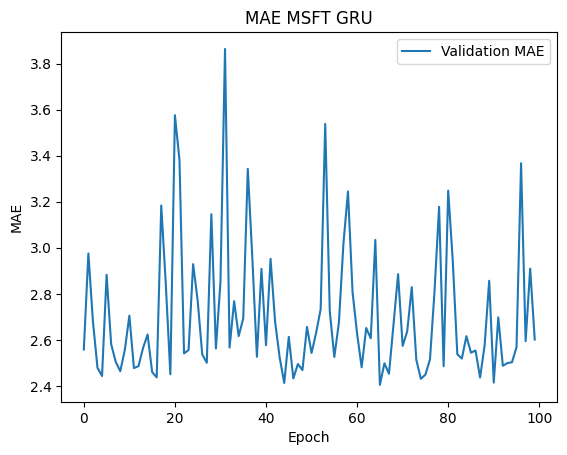

In [35]:
import matplotlib.pyplot as plt

# Assuming you have trained the model
history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

# Extracting training and validation MAE from the history object
#train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

# Plotting the training and validation MAE
#plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE MSFT GRU')
plt.legend()
plt.show()


Epoch 1/100
26/26 [==============================] - 1s 36ms/step - loss: 9.8125 - root_mean_squared_error: 3.0497 - val_loss: 21.5249 - val_root_mean_squared_error: 4.6673
Epoch 2/100
26/26 [==============================] - 1s 20ms/step - loss: 8.8206 - root_mean_squared_error: 2.8697 - val_loss: 10.0951 - val_root_mean_squared_error: 3.1298
Epoch 3/100
26/26 [==============================] - 1s 22ms/step - loss: 8.5936 - root_mean_squared_error: 2.8621 - val_loss: 17.0177 - val_root_mean_squared_error: 3.8363
Epoch 4/100
26/26 [==============================] - 1s 22ms/step - loss: 7.8199 - root_mean_squared_error: 2.7533 - val_loss: 10.0217 - val_root_mean_squared_error: 3.0866
Epoch 5/100
26/26 [==============================] - 0s 17ms/step - loss: 8.3695 - root_mean_squared_error: 2.8643 - val_loss: 10.2965 - val_root_mean_squared_error: 3.0365
Epoch 6/100
26/26 [==============================] - 0s 14ms/step - loss: 7.0865 - root_mean_squared_error: 2.5851 - val_loss: 16.1292 

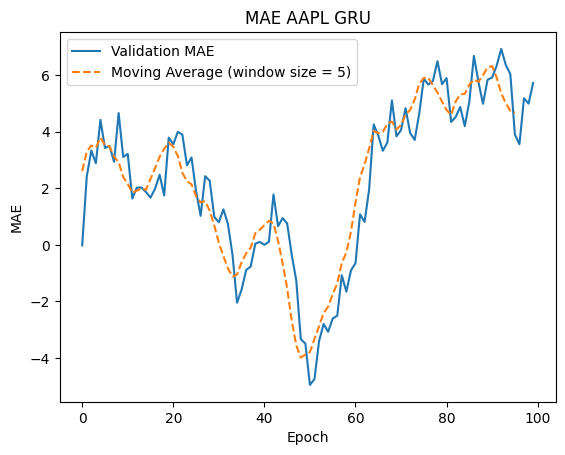

In [33]:
import matplotlib.pyplot as plt
import numpy as np
history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
# Assuming you have trained the model
# This is just a placeholder since we can't actually train the model here.
history = {
    'val_mean_absolute_error': np.random.randn(100).cumsum()  # Random data as an example
}

# Extracting validation MAE from the history object
val_mae = history['val_mean_absolute_error']

# Calculating the moving average of the validation MAE
window_size = 5  # size of the moving window for moving average
moving_average = np.convolve(val_mae, np.ones(window_size)/window_size, mode='valid')

# Plotting the validation MAE and its moving average
plt.plot(val_mae, label='Validation MAE')
plt.plot(moving_average, label='Moving Average (window size = 5)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE AAPL GRU')
plt.legend()
plt.show()

In [36]:
# Assuming you have trained the model and obtained predictions on validation data
loss = gru_model.evaluate(X_val, y_val)

print("Model Loss:", loss)


4/4 [==============================] - 0s 4ms/step - loss: 11.0660 - mean_absolute_error: 2.6013
Model Loss: [11.06602668762207, 2.6013147830963135]


In [37]:
import numpy as np
from sklearn.metrics import r2_score

# Assuming you have trained the model and obtained predictions on validation data
y_pred = gru_model.predict(X_val).flatten()

# Calculate MAE
mae = np.mean(np.abs(y_val - y_pred))

# Calculate RMAE
rmae = np.sqrt(mae)

# Calculate R2 score
r2 = r2_score(y_val, y_pred)

print("GRU Mean Absolute Error (MAE):", mae)
print("GRU Root Mean Absolute Error (RMAE):", rmae)
print("GRU R-squared (R2):", r2)


4/4 [==============================] - 0s 3ms/step
GRU Mean Absolute Error (MAE): 2.6013145
GRU Root Mean Absolute Error (RMAE): 1.6128591
GRU R-squared (R2): 0.9089130676517767


4/4 [==============================] - 0s 8ms/step


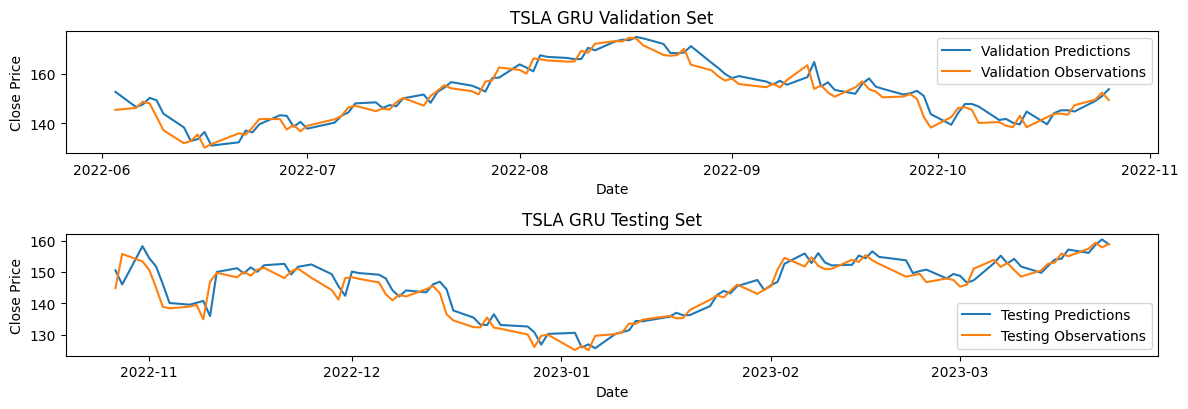

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

#Training set
#plt.subplot(3, 1, 1)
#plt.plot(dates_train, train_predictions, label='Training Predictions')
#plt.plot(dates_train, y_train, label='Training Observations')
#plt.legend()
#plt.title('Training Set')
#plt.xlabel('Date')
#plt.ylabel('Close Price')

# Validation set
val_predictions = gru_model.predict(X_val).flatten()
plt.subplot(3, 1, 2)
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()
plt.title('TSLA GRU Validation Set')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Testing set
test_predictions = gru_model.predict(X_test).flatten()
plt.subplot(3, 1, 3)
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.legend()
plt.title('TSLA GRU Testing Set')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

lstm_model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

lstm_model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
26/26 [==============================] - 4s 43ms/step - loss: 13197.7832 - mean_absolute_error: 107.1039 - val_loss: 21958.4688 - val_mean_absolute_error: 147.7723
Epoch 2/100
26/26 [==============================] - 0s 9ms/step - loss: 12080.6338 - mean_absolute_error: 101.6382 - val_loss: 19357.2422 - val_mean_absolute_error: 138.6910
Epoch 3/100
26/26 [==============================] - 0s 8ms/step - loss: 8939.6611 - mean_absolute_error: 83.2030 - val_loss: 11447.0107 - val_mean_absolute_error: 106.3338
Epoch 4/100
26/26 [==============================] - 0s 9ms/step - loss: 3134.8450 - mean_absolute_error: 46.3308 - val_loss: 2545.6621 - val_mean_absolute_error: 49.2379
Epoch 5/100
26/26 [==============================] - 0s 10ms/step - loss: 1674.0061 - mean_absolute_error: 36.2544 - val_loss: 1537.5626 - val_mean_absolute_error: 37.6734
Epoch 6/100
26/26 [==============================] - 0s 9ms/step - loss: 1208.7009 - mean_absolute_error: 30.6633 - val_loss: 1199.63

Epoch 1/100
26/26 [==============================] - 4s 28ms/step - loss: 13293.4541 - mean_absolute_error: 107.5378 - val_loss: 22221.9727 - val_mean_absolute_error: 148.6615
Epoch 2/100
26/26 [==============================] - 0s 10ms/step - loss: 12443.1113 - mean_absolute_error: 103.4795 - val_loss: 20269.1504 - val_mean_absolute_error: 141.9407
Epoch 3/100
26/26 [==============================] - 0s 10ms/step - loss: 10166.7422 - mean_absolute_error: 91.3414 - val_loss: 15186.9336 - val_mean_absolute_error: 122.7266
Epoch 4/100
26/26 [==============================] - 0s 9ms/step - loss: 5567.0889 - mean_absolute_error: 61.6714 - val_loss: 6174.0723 - val_mean_absolute_error: 77.7626
Epoch 5/100
26/26 [==============================] - 0s 9ms/step - loss: 2055.8582 - mean_absolute_error: 39.6995 - val_loss: 1803.8339 - val_mean_absolute_error: 41.0203
Epoch 6/100
26/26 [==============================] - 0s 11ms/step - loss: 1537.4642 - mean_absolute_error: 34.7829 - val_loss: 1611

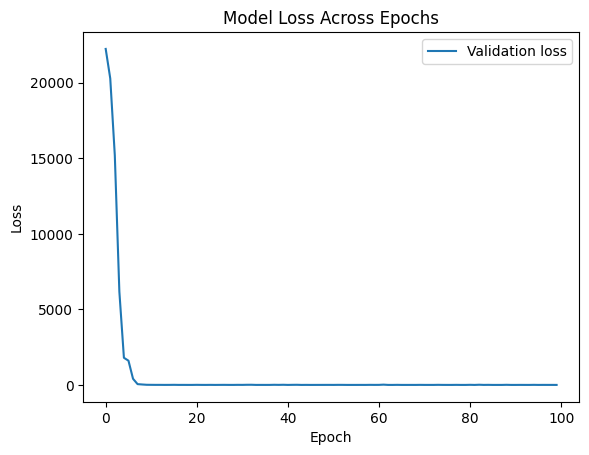

In [40]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Assumed that X_train, y_train, X_val, y_val are defined here.

lstm_model = Sequential([
    LSTM(64, input_shape=(3, 1)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mean_absolute_error'])

history = lstm_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=100,
                         batch_size=32,
                         verbose=1)

#plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Epoch 1/100
26/26 [==============================] - 0s 8ms/step - loss: 5.9257 - mean_absolute_error: 1.7855 - val_loss: 13.2496 - val_mean_absolute_error: 2.8848
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 6.3552 - mean_absolute_error: 1.8153 - val_loss: 9.6767 - val_mean_absolute_error: 2.4620
Epoch 3/100
26/26 [==============================] - 0s 9ms/step - loss: 6.0005 - mean_absolute_error: 1.7422 - val_loss: 10.0423 - val_mean_absolute_error: 2.5642
Epoch 4/100
26/26 [==============================] - 0s 9ms/step - loss: 7.1939 - mean_absolute_error: 1.9494 - val_loss: 9.6021 - val_mean_absolute_error: 2.4177
Epoch 5/100
26/26 [==============================] - 0s 9ms/step - loss: 7.5180 - mean_absolute_error: 2.1094 - val_loss: 15.5260 - val_mean_absolute_error: 3.3416
Epoch 6/100
26/26 [==============================] - 0s 9ms/step - loss: 6.4162 - mean_absolute_error: 1.8102 - val_loss: 18.4960 - val_mean_absolute_error: 3.6271
Epoch 7/100
26/26 

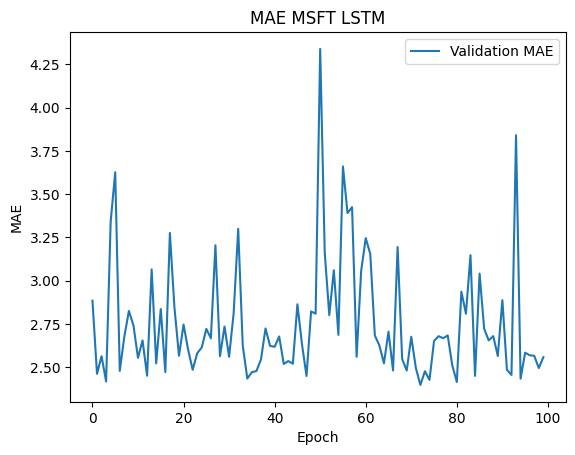

In [41]:
import matplotlib.pyplot as plt

# Assuming you have trained the model
history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

# Extracting training and validation MAE from the history object
#train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

# Plotting the training and validation MAE
#plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE MSFT LSTM')
plt.legend()
plt.show()


Epoch 1/100
26/26 [==============================] - 0s 13ms/step - loss: 5.9964 - mean_absolute_error: 1.7721 - val_loss: 11.2447 - val_mean_absolute_error: 2.6605
Epoch 2/100
26/26 [==============================] - 0s 9ms/step - loss: 5.7267 - mean_absolute_error: 1.7103 - val_loss: 10.1286 - val_mean_absolute_error: 2.5637
Epoch 3/100
26/26 [==============================] - 0s 8ms/step - loss: 5.6096 - mean_absolute_error: 1.6689 - val_loss: 9.5470 - val_mean_absolute_error: 2.4267
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 6.2599 - mean_absolute_error: 1.7803 - val_loss: 12.2140 - val_mean_absolute_error: 2.8238
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 5.8465 - mean_absolute_error: 1.7129 - val_loss: 11.7471 - val_mean_absolute_error: 2.7201
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 5.9819 - mean_absolute_error: 1.7170 - val_loss: 12.9622 - val_mean_absolute_error: 2.8417
Epoch 7/100
26/2

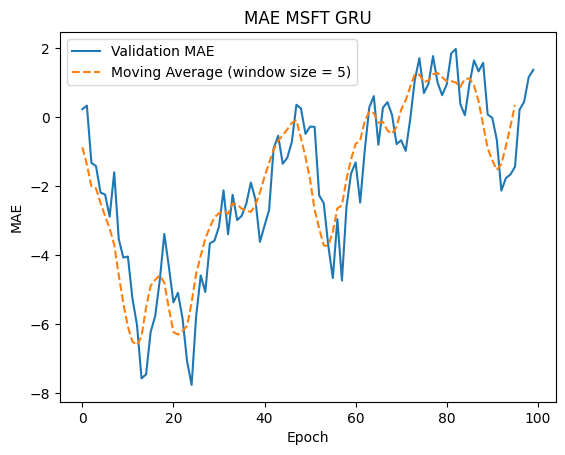

In [42]:
import matplotlib.pyplot as plt
import numpy as np
history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
# Assuming you have trained the model
# This is just a placeholder since we can't actually train the model here.
history = {
    'val_mean_absolute_error': np.random.randn(100).cumsum()  # Random data as an example
}

# Extracting validation MAE from the history object
val_mae = history['val_mean_absolute_error']

# Calculating the moving average of the validation MAE
window_size = 5  # size of the moving window for moving average
moving_average = np.convolve(val_mae, np.ones(window_size)/window_size, mode='valid')

# Plotting the validation MAE and its moving average
plt.plot(val_mae, label='Validation MAE')
plt.plot(moving_average, label='Moving Average (window size = 5)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE MSFT GRU')
plt.legend()
plt.show()

In [43]:
import numpy as np
from sklearn.metrics import r2_score

# Assuming you have trained the model and obtained predictions on validation data
y_pred = lstm_model.predict(X_val).flatten()

# Calculate MAE
mae = np.mean(np.abs(y_val - y_pred))

# Calculate RMAE
rmae = np.sqrt(mae)

# Calculate R2 score
r2 = r2_score(y_val, y_pred)

print("LSTM Mean Absolute Error (MAE):", mae)
print("LSTM Root Mean Absolute Error (RMAE):", rmae)
print("LSTM R-squared (R2):", r2)


4/4 [==============================] - 1s 6ms/step
LSTM Mean Absolute Error (MAE): 2.471966
LSTM Root Mean Absolute Error (RMAE): 1.5722487
LSTM R-squared (R2): 0.9194819146433693


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

#Training set
#plt.subplot(3, 1, 1)
#plt.plot(dates_train, train_predictions, label='Training Predictions')
#plt.plot(dates_train, y_train, label='Training Observations')
#plt.legend()
#plt.title('Training Set')
#plt.xlabel('Date')
#plt.ylabel('Close Price')

# Validation set
val_predictions = lstm_model.predict(X_val).flatten()
plt.subplot(3, 1, 2)
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()
plt.title('TSLA LSTM Validation Set')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Testing set
test_predictions = lstm_model.predict(X_test).flatten()
plt.subplot(3, 1, 3)
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.legend()
plt.title('TSLA LSTM Testing Set')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

In [44]:
import tensorflow as tf
from tensorflow.keras import layers
import time


def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, rate=0.1, epsilon=1e-6):
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=embed_dim, num_heads=num_heads, dropout=rate
    )(x, x)
    x = layers.Dropout(rate)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(rate)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer(embed_dim, num_heads, ff_dim, num_trans_blocks, mlp_units, rate=0.1, mlp_dropout=0, epsilon=1e-6):
    n_timesteps, n_features, n_outputs = 3, 1, 1
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)

def fit_transformer(transformer: tf.keras.Model, data):
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", "mape"]
    )
# Define model parameters
embed_dim = 32
num_heads = 2
ff_dim = 32
num_trans_blocks = 3
mlp_units = [32]
rate = 0.1
mlp_dropout = 0
epsilon = 1e-6

# Build the transformer model
transformer_model = build_transformer(embed_dim, num_heads, ff_dim, num_trans_blocks, mlp_units, rate, mlp_dropout, epsilon)
fit_transformer(transformer_model, df)
transformer_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)


Epoch 1/200
26/26 [==============================] - 21s 37ms/step - loss: 16104.9229 - mae: 118.3289 - mape: 108.7547 - val_loss: 22566.6855 - val_mae: 149.8235 - val_mape: 99.0832
Epoch 2/200
26/26 [==============================] - 1s 26ms/step - loss: 11180.8359 - mae: 98.7014 - mape: 90.8575 - val_loss: 15216.2129 - val_mae: 123.0136 - val_mape: 81.3453
Epoch 3/200
26/26 [==============================] - 1s 20ms/step - loss: 7285.6484 - mae: 79.6331 - mape: 73.3213 - val_loss: 9480.6465 - val_mae: 97.0772 - val_mape: 64.1840
Epoch 4/200
26/26 [==============================] - 1s 21ms/step - loss: 4318.1699 - mae: 61.0853 - mape: 56.0457 - val_loss: 5211.7285 - val_mae: 71.9343 - val_mape: 47.5453
Epoch 5/200
26/26 [==============================] - 1s 21ms/step - loss: 2184.0635 - mae: 42.9925 - mape: 39.0894 - val_loss: 2383.1765 - val_mae: 48.5609 - val_mape: 32.0731
Epoch 6/200
26/26 [==============================] - 1s 20ms/step - loss: 875.0767 - mae: 26.4676 - mape: 23.36

Epoch 1/100
26/26 [==============================] - 7s 45ms/step - loss: 8.1693 - mean_absolute_error: 2.0405 - val_loss: 14.9876 - val_mean_absolute_error: 3.1734
Epoch 2/100
26/26 [==============================] - 1s 20ms/step - loss: 7.9265 - mean_absolute_error: 2.0064 - val_loss: 15.1210 - val_mean_absolute_error: 3.1574
Epoch 3/100
26/26 [==============================] - 0s 15ms/step - loss: 8.0650 - mean_absolute_error: 2.0242 - val_loss: 14.2181 - val_mean_absolute_error: 3.0917
Epoch 4/100
26/26 [==============================] - 0s 14ms/step - loss: 8.0230 - mean_absolute_error: 2.0068 - val_loss: 17.4240 - val_mean_absolute_error: 3.3109
Epoch 5/100
26/26 [==============================] - 0s 12ms/step - loss: 8.2123 - mean_absolute_error: 2.0320 - val_loss: 14.2420 - val_mean_absolute_error: 3.1032
Epoch 6/100
26/26 [==============================] - 0s 11ms/step - loss: 7.7692 - mean_absolute_error: 1.9683 - val_loss: 14.2175 - val_mean_absolute_error: 3.0917
Epoch 7/10

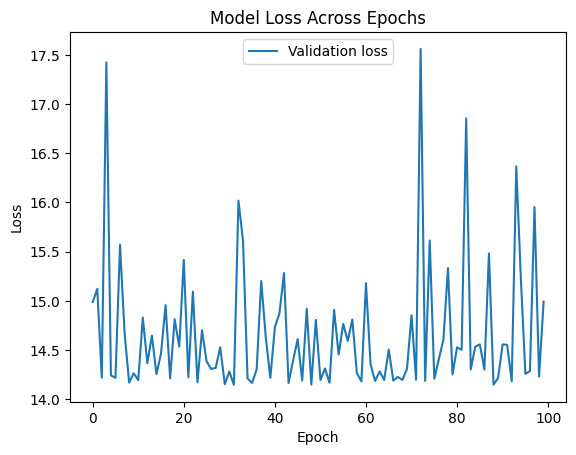

In [45]:
transformer_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mean_absolute_error'])

history = transformer_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=100,
                         batch_size=32,
                         verbose=1)

#plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [46]:
import matplotlib.pyplot as plt

# Assuming you have trained the model
history = transformer_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

# Extracting training and validation MAE from the history object
#train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plotting the training and validation MAE
#plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE MSFT Transformer')
plt.legend()
plt.show()


Epoch 1/200
26/26 [==============================] - 0s 19ms/step - loss: 7.8257 - mean_absolute_error: 1.9910 - val_loss: 14.1721 - val_mean_absolute_error: 3.0976
Epoch 2/200
26/26 [==============================] - 0s 15ms/step - loss: 7.8147 - mean_absolute_error: 1.9795 - val_loss: 14.3357 - val_mean_absolute_error: 3.1078
Epoch 3/200
26/26 [==============================] - 0s 15ms/step - loss: 7.8651 - mean_absolute_error: 1.9965 - val_loss: 14.1539 - val_mean_absolute_error: 3.0945
Epoch 4/200
26/26 [==============================] - 0s 14ms/step - loss: 7.9792 - mean_absolute_error: 2.0030 - val_loss: 14.1893 - val_mean_absolute_error: 3.0993
Epoch 5/200
26/26 [==============================] - 0s 15ms/step - loss: 8.2720 - mean_absolute_error: 2.0540 - val_loss: 14.5618 - val_mean_absolute_error: 3.1238
Epoch 6/200
26/26 [==============================] - 0s 14ms/step - loss: 7.8349 - mean_absolute_error: 1.9984 - val_loss: 14.8811 - val_mean_absolute_error: 3.1448
Epoch 7/20

KeyError: 'val_mae'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have trained the model
# This is just a placeholder since we can't actually train the model here.
history = {
    'val_mean_absolute_error': np.random.randn(200).cumsum()  # Random data as an example
}

# Extracting validation MAE from the history object
val_mae = history['val_mean_absolute_error']

# Calculating the moving average of the validation MAE
window_size = 5  # size of the moving window for moving average
moving_average = np.convolve(val_mae, np.ones(window_size)/window_size, mode='valid')

# Plotting the validation MAE and its moving average
plt.plot(val_mae, label='Validation MAE')
plt.plot(moving_average, label='Moving Average (window size = 5)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE MSFT GRU')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Assuming you have trained the model and obtained predictions on validation data
y_pred = transformer_model.predict(X_val).flatten()

# Calculate MAE
mae = np.mean(np.abs(y_val - y_pred))

# Calculate RMAE
rmae = np.sqrt(mae)

# Calculate R2 score
r2 = r2_score(y_val, y_pred)

print("Transformer Mean Absolute Error (MAE):", mae)
print("Transformer Root Mean Absolute Error (RMAE):", rmae)
print("Transformer R-squared (R2):", r2)



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

#Training set
#plt.subplot(3, 1, 1)
#plt.plot(dates_train, train_predictions, label='Training Predictions')
#plt.plot(dates_train, y_train, label='Training Observations')
#plt.legend()
#plt.title('Training Set')
#plt.xlabel('Date')
#plt.ylabel('Close Price')

# Validation set
val_predictions = transformer_model.predict(X_val).flatten()
plt.subplot(3, 1, 2)
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()
plt.title('TSLA Transformer Validation Set')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Testing set
test_predictions = transformer_model.predict(X_test).flatten()
plt.subplot(3, 1, 3)
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.legend()
plt.title('TSLA Transformer Testing Set')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

In [ ]:
# Validation set
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
val_predictions = lstm_model.predict(X_val).flatten()
gru_preds = gru_model.predict(X_val).flatten()
lstm_preds = lstm_model.predict(X_val).flatten()
transformer_preds = transformer_model.predict(X_val).flatten()
plt.subplot(3, 1, 2)
#plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.plot(dates_val, gru_preds, label='GRU Predictions')
plt.plot(dates_val, lstm_preds, label='LSTM Predictions')
plt.plot(dates_val, transformer_preds, label='Transformer Pedictions')
plt.legend()
plt.title('MSFT All Models Validation Set')
plt.xlabel('Date')
plt.ylabel('Close Price')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# Testing set
test_predictions = lstm_model.predict(X_test).flatten()
gru_preds = gru_model.predict(X_test).flatten()
lstm_preds = lstm_model.predict(X_test).flatten()
transformer_preds = transformer_model.predict(X_test).flatten()
plt.subplot(3, 1, 3)
#plt.plot(dates_test, test_predictions, label='Test_predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.plot(dates_test, gru_preds, label='GRU Predictions')
plt.plot(dates_test, lstm_preds, label='LSTM Predictions')
plt.plot(dates_test, transformer_preds, label='Transformer Pedictions')


plt.legend()
plt.title('MSFT All Models Testing Set')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()